In [39]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [40]:
DATASET_PATH = "./fonts_dataset"

images = []
labels = []

for filename in os.listdir(DATASET_PATH):
    if filename.endswith(".png"):
        parts = filename.replace(".png", "").split("_")
        font_label = parts[1]

        img_path = os.path.join(DATASET_PATH, filename)
        img = Image.open(img_path).convert("L")  # grayscale
        img_array = np.array(img)

        images.append(img_array)
        labels.append(font_label)

X = np.array(images)  # shape: (num_samples, H, W)
y = np.array(labels)

print(f"Loaded {len(X)} images.")


Loaded 35000 images.


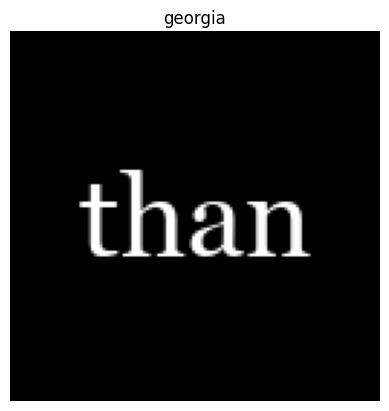

In [41]:
plt.imshow(df.iloc[sample_index]["pixels"], cmap="gray")
plt.title(df.iloc[sample_index]["font"])
plt.axis("off")
plt.show()

In [42]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}")


Train samples: 28000, Validation samples: 7000


In [44]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean
    
    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

In [46]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

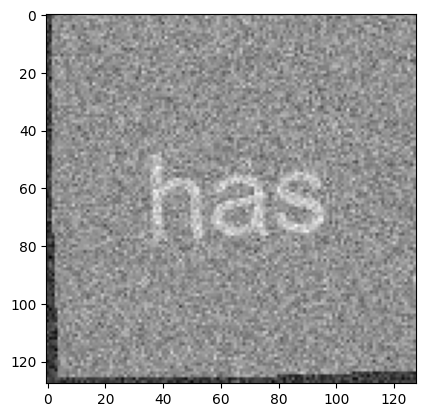

In [ ]:
sample_img, _ = train_dataset[0]
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()


In [51]:
train_dataset[0][0].shape

torch.Size([1, 224, 224])

In [48]:
class FontDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]  # shape: (H,W)
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, torch.tensor(label, dtype=torch.long)

In [49]:
batch_size = 64

train_dataset = FontDataset(X_train, y_train, transform=train_transform)
val_dataset = FontDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)